<a href="https://colab.research.google.com/github/Vadimbuildercxx/AI-Learning/blob/main/Hands_on_ml3/Chapter2_Assigment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall scikit-learn -y

!pip install -U scikit-learn

Found existing installation: scikit-learn 1.2.1
Uninstalling scikit-learn-1.2.1:
  Successfully uninstalled scikit-learn-1.2.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scikit_learn-1.2.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.8 MB)


In [ ]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [ ]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


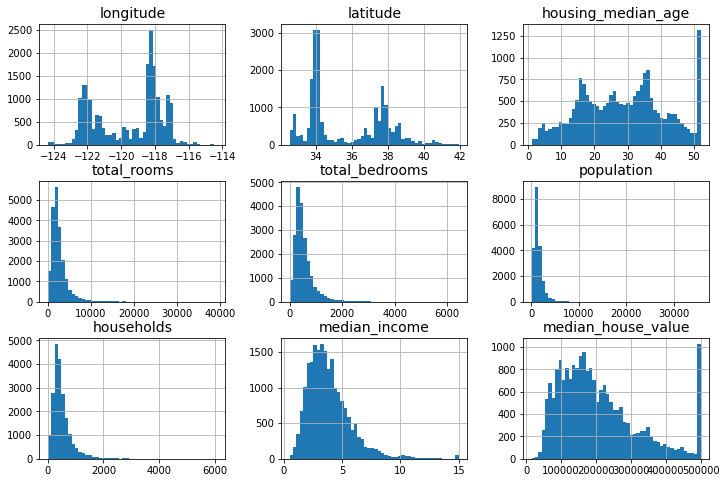

In [ ]:
import matplotlib.pyplot as plt

# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=50, figsize=(12, 8))
plt.show()

In [ ]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [ ]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
len(train_set)

16512

In [ ]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [ ]:
housing_with_id = housing.reset_index()  # adds an `index` column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

In [ ]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [ ]:
test_set["total_bedrooms"].isnull().sum()

44

In [ ]:
# extra code – shows how to compute the 10.7% proba of getting a bad sample

from scipy.stats import binom

sample_size = 1000
ratio_female = 0.511
proba_too_small = binom(sample_size, ratio_female).cdf(485 - 1)
proba_too_large = 1 - binom(sample_size, ratio_female).cdf(535)
print(proba_too_small + proba_too_large)
print(proba_too_small, proba_too_large)

0.10736798530929913
0.04684502186344951 0.06052296344584962


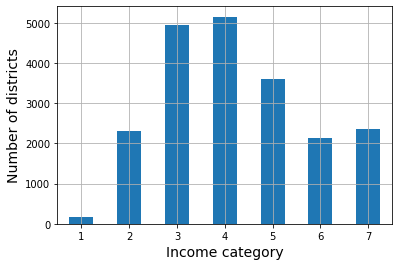

In [ ]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1., 2., 3.0, 4., 5., 6., np.inf],
                               labels=[1, 2, 3, 4, 5, 6, 7])

housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])
    
strat_train_set, strat_test_set = strat_splits[0]

In [ ]:
# extra code – computes the data for Figure 2–10

def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)
(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,0.77,0.78,0.75,0.63,-2.52
2,11.13,11.14,11.39,0.09,2.26
3,23.96,23.96,22.84,-0.02,-4.67
4,24.95,24.95,24.39,0.00,-2.23
5,17.43,17.44,17.90,0.06,2.70
6,10.31,10.30,10.63,-0.09,3.20
7,11.44,11.43,12.09,-0.08,5.63


In [ ]:
housing = strat_train_set.copy()

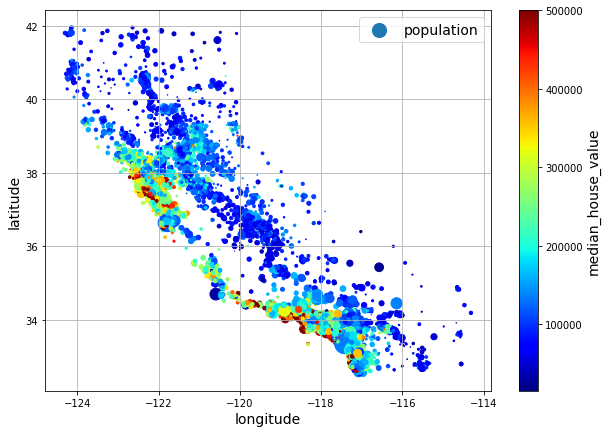

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] /90, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
plt.show()

In [ ]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.689236
total_rooms           0.130833
housing_median_age    0.100575
households            0.063383
total_bedrooms        0.048154
population           -0.028708
longitude            -0.051584
latitude             -0.140173
Name: median_house_value, dtype: float64

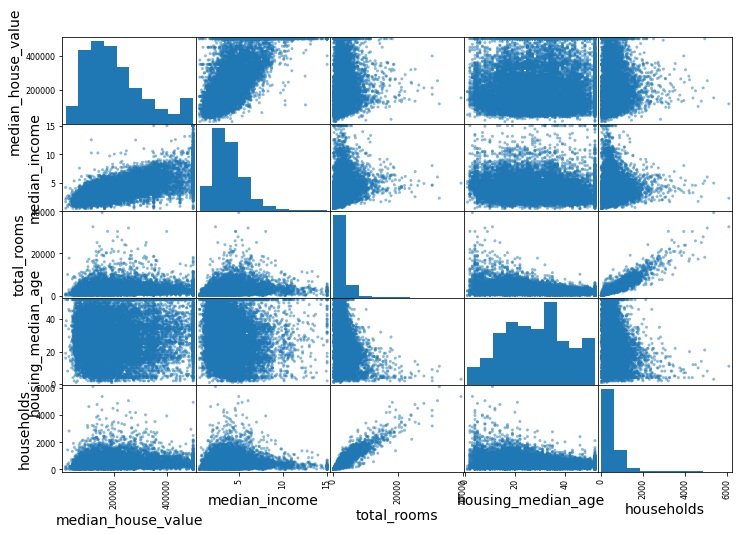

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age", "households"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

In [ ]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]
housing["households_per_room"] = housing["households"] / housing["total_rooms"]

In [ ]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value     1.000000
median_income          0.689236
rooms_per_house        0.159861
total_rooms            0.130833
housing_median_age     0.100575
households             0.063383
total_bedrooms         0.048154
people_per_house      -0.022195
population            -0.028708
longitude             -0.051584
latitude              -0.140173
households_per_room   -0.219212
bedrooms_ratio        -0.258347
Name: median_house_value, dtype: float64

In [ ]:
# from sklearn.ensemble import IsolationForest

# isolation_forest = IsolationForest(random_state=42)
# outlier_pred = isolation_forest.fit_predict(X) == 1
# len(outlier_pred)

In [ ]:
housing.shape

(16512, 15)

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.compose import ColumnTransformer, make_column_selector

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())
    

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, MetaEstimatorMixin, clone, TransformerMixin
from sklearn.neighbors import KNeighborsRegressor
from tempfile import mkdtemp

In [ ]:
class ColumnDropperTransformer(BaseEstimator):
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        if set(self.columns).issubset(X.columns):
          return X.drop(self.columns,axis=1)
        else:
          return X

    def fit(self, X, y=None):
        return self 

class EstimatorTransformer(MetaEstimatorMixin, BaseEstimator, TransformerMixin):
    def __init__(self, estimator):
        self.estimator = estimator
        #self.prefited_ = prefited
        self.name_ = self.estimator.__class__.__name__ 

    def fit(self, X, y=None):
        estimator_ = clone(self.estimator)
        estimator_.fit(X, y)
        self.estimator_ = estimator_
        self.n_features_in_ = self.estimator_.n_features_in_
        if hasattr(self.estimator, "feature_names_in_"):
            self.feature_names_in_ = self.estimator.feature_names_in_
        return self 

    def transform(self,X,y=None):
        self.knr_pred = pd.DataFrame(data = self.estimator_.predict(X), columns=[self.name_ + "_pred"])
        return self.knr_pred

    

    def get_feature_names_out(self, names=None):
        return [self.name_]

knr = KNeighborsRegressor(n_neighbors=3,weights="distance")

preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("households_per_room", ratio_pipeline(), ["households","total_rooms"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("knr_transformer", EstimatorTransformer(knr), ["latitude", "longitude"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline
    ) 
 
rf_clf = RandomForestClassifier(random_state=42, max_depth=4)

cachedir = mkdtemp()
prepare_pipe = Pipeline([
    ("column_drop", ColumnDropperTransformer(["median_house_value"])),
    ("prepare", preprocessing),
    ("feature_selection", SelectFromModel(rf_clf, prefit=False, threshold=0.005)),
                         ], memory=cachedir)


In [ ]:
data_out = prepare_pipe.fit_transform(housing, housing["median_house_value"])
columns_out = prepare_pipe["feature_selection"].get_feature_names_out(prepare_pipe["prepare"].get_feature_names_out())
#columns_out = prepare_pipe["prepare"].get_feature_names_out()

pd.DataFrame(data=data_out, columns = columns_out).head(4)

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,bedrooms__ratio,rooms_per_house__ratio,people_per_house__ratio,households_per_room__ratio,log__total_rooms,log__median_income,knr_transformer__KNeighborsRegressor,geo__Cluster 2 similarity,geo__Cluster 3 similarity,geo__Cluster 4 similarity,geo__Cluster 7 similarity,geo__Cluster 8 similarity,geo__Cluster 9 similarity,cat__ocean_proximity_INLAND,remainder__housing_median_age,remainder__income_cat,remainder__rooms_per_house,remainder__bedrooms_ratio,remainder__people_per_house,remainder__households_per_room
0,4.211101,-1.412634,0.031866,4.716008,-0.598779,-1.840961,157966.666667,5.272578e-10,0.000262,4.897676e-02,0.078434,5.993244e-15,9.999833e-01,0.0,-0.045045,-1.471546,-1.412634,4.834740,0.031866,4.716008
1,0.037617,-0.386842,-0.091960,0.386769,0.529231,1.209062,411350.500000,2.716492e-01,0.001228,1.307814e-20,0.000006,4.952745e-02,1.054155e-11,0.0,-0.836811,1.815366,-0.386842,0.059363,-0.091960,0.386769
2,-0.084864,-0.207888,-0.082876,0.052854,-0.513275,-0.347479,257400.000000,1.185668e-09,0.000455,3.812489e-02,0.093023,1.728826e-14,9.881103e-01,0.0,1.617664,-0.814164,-0.207888,-0.080781,-0.082876,0.052854
3,0.359916,-0.384301,-0.070457,0.381604,-0.526668,-1.052999,98400.000000,1.920208e-08,0.003127,1.164958e-02,0.100942,8.577586e-13,6.508751e-01,1.0,1.538487,-0.814164,-0.384301,0.428144,-0.070457,0.381604


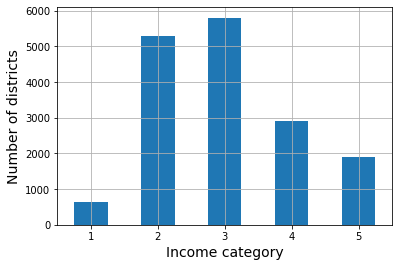

In [ ]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

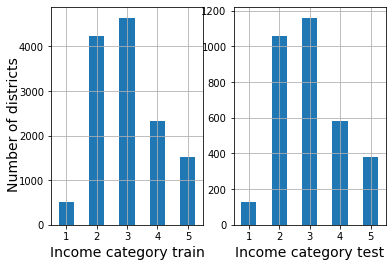

In [ ]:
train, test = train_test_split(
    housing, test_size=0.2, 
    stratify=housing["income_cat"], random_state=42)

X_train, y_train = (train.drop(columns = ["median_house_value"]), 
        train["median_house_value"])
X_test, y_test = (test.drop(columns = ["median_house_value"]), 
        test["median_house_value"])

fig, ax = plt.subplots(1, 2)
train["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True, ax=ax[0])
ax[0].set_xlabel("Income category train")

test["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True, ax=ax[1])
ax[1].set_xlabel("Income category test")
fig.text(0.04, 0.25, 'Number of districts', ha='center', rotation='vertical')

plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from scipy.stats import randint, expon, reciprocal

In [ ]:
param_grid = [
    {
     #'preprocessing__prepare__geo__n_clusters': [5, 8, 10],
     "svm_regressor__kernel":["linear","rbf"],
     'svm_regressor__C': reciprocal(20, 200_000),
     "svm_regressor__gamma": expon(scale=1.0),
     },
]
params_best = [{
 'preprocessing__prepare__knr_transformer__estimator__n_neighbors': range(1, 30),
 'preprocessing__prepare__knr_transformer__estimator__weights': ["distance", "uniform"],
 }]

In [ ]:
full_pipeline = Pipeline([
    ("preprocessing", prepare_pipe),
    ("svm_regressor", SVR(C=157055.10989448498, gamma = 0.26497040005002437, kernel='rbf')),
], memory="content")

rnd_search = RandomizedSearchCV(full_pipeline, params_best, cv=3,
                           scoring='neg_root_mean_squared_error', verbose=10)

rnd_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3; 1/10] START preprocessing__prepare__knr_transformer__estimator__n_neighbors=16, preprocessing__prepare__knr_transformer__estimator__weights=distance


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV 1/3; 1/10] END preprocessing__prepare__knr_transformer__estimator__n_neighbors=16, preprocessing__prepare__knr_transformer__estimator__weights=distance;, score=-104636.640 total time= 1.1min
[CV 2/3; 1/10] START preprocessing__prepare__knr_transformer__estimator__n_neighbors=16, preprocessing__prepare__knr_transformer__estimator__weights=distance


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV 2/3; 1/10] END preprocessing__prepare__knr_transformer__estimator__n_neighbors=16, preprocessing__prepare__knr_transformer__estimator__weights=distance;, score=-103688.969 total time= 1.1min
[CV 3/3; 1/10] START preprocessing__prepare__knr_transformer__estimator__n_neighbors=16, preprocessing__prepare__knr_transformer__estimator__weights=distance


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV 3/3; 1/10] END preprocessing__prepare__knr_transformer__estimator__n_neighbors=16, preprocessing__prepare__knr_transformer__estimator__weights=distance;, score=-103470.220 total time= 1.0min
[CV 1/3; 2/10] START preprocessing__prepare__knr_transformer__estimator__n_neighbors=18, preprocessing__prepare__knr_transformer__estimator__weights=distance


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV 1/3; 2/10] END preprocessing__prepare__knr_transformer__estimator__n_neighbors=18, preprocessing__prepare__knr_transformer__estimator__weights=distance;, score=-104669.744 total time= 1.1min
[CV 2/3; 2/10] START preprocessing__prepare__knr_transformer__estimator__n_neighbors=18, preprocessing__prepare__knr_transformer__estimator__weights=distance


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV 2/3; 2/10] END preprocessing__prepare__knr_transformer__estimator__n_neighbors=18, preprocessing__prepare__knr_transformer__estimator__weights=distance;, score=-103712.744 total time= 1.1min
[CV 3/3; 2/10] START preprocessing__prepare__knr_transformer__estimator__n_neighbors=18, preprocessing__prepare__knr_transformer__estimator__weights=distance


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV 3/3; 2/10] END preprocessing__prepare__knr_transformer__estimator__n_neighbors=18, preprocessing__prepare__knr_transformer__estimator__weights=distance;, score=-103513.006 total time= 1.1min
[CV 1/3; 3/10] START preprocessing__prepare__knr_transformer__estimator__n_neighbors=24, preprocessing__prepare__knr_transformer__estimator__weights=distance


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV 1/3; 3/10] END preprocessing__prepare__knr_transformer__estimator__n_neighbors=24, preprocessing__prepare__knr_transformer__estimator__weights=distance;, score=-104705.441 total time= 1.1min
[CV 2/3; 3/10] START preprocessing__prepare__knr_transformer__estimator__n_neighbors=24, preprocessing__prepare__knr_transformer__estimator__weights=distance


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV 2/3; 3/10] END preprocessing__prepare__knr_transformer__estimator__n_neighbors=24, preprocessing__prepare__knr_transformer__estimator__weights=distance;, score=-103730.987 total time= 1.2min
[CV 3/3; 3/10] START preprocessing__prepare__knr_transformer__estimator__n_neighbors=24, preprocessing__prepare__knr_transformer__estimator__weights=distance


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV 3/3; 3/10] END preprocessing__prepare__knr_transformer__estimator__n_neighbors=24, preprocessing__prepare__knr_transformer__estimator__weights=distance;, score=-103577.449 total time= 1.2min
[CV 1/3; 4/10] START preprocessing__prepare__knr_transformer__estimator__n_neighbors=3, preprocessing__prepare__knr_transformer__estimator__weights=uniform


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV 1/3; 4/10] END preprocessing__prepare__knr_transformer__estimator__n_neighbors=3, preprocessing__prepare__knr_transformer__estimator__weights=uniform;, score=-95754.947 total time= 1.1min
[CV 2/3; 4/10] START preprocessing__prepare__knr_transformer__estimator__n_neighbors=3, preprocessing__prepare__knr_transformer__estimator__weights=uniform


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV 2/3; 4/10] END preprocessing__prepare__knr_transformer__estimator__n_neighbors=3, preprocessing__prepare__knr_transformer__estimator__weights=uniform;, score=-92669.634 total time= 1.0min
[CV 3/3; 4/10] START preprocessing__prepare__knr_transformer__estimator__n_neighbors=3, preprocessing__prepare__knr_transformer__estimator__weights=uniform


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV 3/3; 4/10] END preprocessing__prepare__knr_transformer__estimator__n_neighbors=3, preprocessing__prepare__knr_transformer__estimator__weights=uniform;, score=-93517.483 total time=  59.4s
[CV 1/3; 5/10] START preprocessing__prepare__knr_transformer__estimator__n_neighbors=23, preprocessing__prepare__knr_transformer__estimator__weights=distance


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV 1/3; 5/10] END preprocessing__prepare__knr_transformer__estimator__n_neighbors=23, preprocessing__prepare__knr_transformer__estimator__weights=distance;, score=-104713.848 total time= 1.1min
[CV 2/3; 5/10] START preprocessing__prepare__knr_transformer__estimator__n_neighbors=23, preprocessing__prepare__knr_transformer__estimator__weights=distance


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV 2/3; 5/10] END preprocessing__prepare__knr_transformer__estimator__n_neighbors=23, preprocessing__prepare__knr_transformer__estimator__weights=distance;, score=-103616.313 total time= 1.0min
[CV 3/3; 5/10] START preprocessing__prepare__knr_transformer__estimator__n_neighbors=23, preprocessing__prepare__knr_transformer__estimator__weights=distance


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV 3/3; 5/10] END preprocessing__prepare__knr_transformer__estimator__n_neighbors=23, preprocessing__prepare__knr_transformer__estimator__weights=distance;, score=-103469.292 total time= 1.1min
[CV 1/3; 6/10] START preprocessing__prepare__knr_transformer__estimator__n_neighbors=12, preprocessing__prepare__knr_transformer__estimator__weights=distance


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV 1/3; 6/10] END preprocessing__prepare__knr_transformer__estimator__n_neighbors=12, preprocessing__prepare__knr_transformer__estimator__weights=distance;, score=-104546.160 total time= 1.1min
[CV 2/3; 6/10] START preprocessing__prepare__knr_transformer__estimator__n_neighbors=12, preprocessing__prepare__knr_transformer__estimator__weights=distance


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV 2/3; 6/10] END preprocessing__prepare__knr_transformer__estimator__n_neighbors=12, preprocessing__prepare__knr_transformer__estimator__weights=distance;, score=-103330.274 total time= 1.1min
[CV 3/3; 6/10] START preprocessing__prepare__knr_transformer__estimator__n_neighbors=12, preprocessing__prepare__knr_transformer__estimator__weights=distance


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV 3/3; 6/10] END preprocessing__prepare__knr_transformer__estimator__n_neighbors=12, preprocessing__prepare__knr_transformer__estimator__weights=distance;, score=-103210.371 total time= 1.1min
[CV 1/3; 7/10] START preprocessing__prepare__knr_transformer__estimator__n_neighbors=6, preprocessing__prepare__knr_transformer__estimator__weights=uniform


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV 1/3; 7/10] END preprocessing__prepare__knr_transformer__estimator__n_neighbors=6, preprocessing__prepare__knr_transformer__estimator__weights=uniform;, score=-99433.682 total time= 1.1min
[CV 2/3; 7/10] START preprocessing__prepare__knr_transformer__estimator__n_neighbors=6, preprocessing__prepare__knr_transformer__estimator__weights=uniform


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV 2/3; 7/10] END preprocessing__prepare__knr_transformer__estimator__n_neighbors=6, preprocessing__prepare__knr_transformer__estimator__weights=uniform;, score=-98194.597 total time=  58.1s
[CV 3/3; 7/10] START preprocessing__prepare__knr_transformer__estimator__n_neighbors=6, preprocessing__prepare__knr_transformer__estimator__weights=uniform


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV 3/3; 7/10] END preprocessing__prepare__knr_transformer__estimator__n_neighbors=6, preprocessing__prepare__knr_transformer__estimator__weights=uniform;, score=-98759.607 total time= 1.0min
[CV 1/3; 8/10] START preprocessing__prepare__knr_transformer__estimator__n_neighbors=24, preprocessing__prepare__knr_transformer__estimator__weights=uniform


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV 1/3; 8/10] END preprocessing__prepare__knr_transformer__estimator__n_neighbors=24, preprocessing__prepare__knr_transformer__estimator__weights=uniform;, score=-104349.683 total time= 1.1min
[CV 2/3; 8/10] START preprocessing__prepare__knr_transformer__estimator__n_neighbors=24, preprocessing__prepare__knr_transformer__estimator__weights=uniform


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV 2/3; 8/10] END preprocessing__prepare__knr_transformer__estimator__n_neighbors=24, preprocessing__prepare__knr_transformer__estimator__weights=uniform;, score=-103613.922 total time= 1.0min
[CV 3/3; 8/10] START preprocessing__prepare__knr_transformer__estimator__n_neighbors=24, preprocessing__prepare__knr_transformer__estimator__weights=uniform


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV 3/3; 8/10] END preprocessing__prepare__knr_transformer__estimator__n_neighbors=24, preprocessing__prepare__knr_transformer__estimator__weights=uniform;, score=-103725.047 total time= 1.0min
[CV 1/3; 9/10] START preprocessing__prepare__knr_transformer__estimator__n_neighbors=15, preprocessing__prepare__knr_transformer__estimator__weights=distance


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV 1/3; 9/10] END preprocessing__prepare__knr_transformer__estimator__n_neighbors=15, preprocessing__prepare__knr_transformer__estimator__weights=distance;, score=-104529.645 total time= 1.1min
[CV 2/3; 9/10] START preprocessing__prepare__knr_transformer__estimator__n_neighbors=15, preprocessing__prepare__knr_transformer__estimator__weights=distance


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV 2/3; 9/10] END preprocessing__prepare__knr_transformer__estimator__n_neighbors=15, preprocessing__prepare__knr_transformer__estimator__weights=distance;, score=-103769.704 total time= 1.0min
[CV 3/3; 9/10] START preprocessing__prepare__knr_transformer__estimator__n_neighbors=15, preprocessing__prepare__knr_transformer__estimator__weights=distance


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV 3/3; 9/10] END preprocessing__prepare__knr_transformer__estimator__n_neighbors=15, preprocessing__prepare__knr_transformer__estimator__weights=distance;, score=-103515.217 total time= 1.0min
[CV 1/3; 10/10] START preprocessing__prepare__knr_transformer__estimator__n_neighbors=21, preprocessing__prepare__knr_transformer__estimator__weights=uniform


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV 1/3; 10/10] END preprocessing__prepare__knr_transformer__estimator__n_neighbors=21, preprocessing__prepare__knr_transformer__estimator__weights=uniform;, score=-103950.272 total time= 1.1min
[CV 2/3; 10/10] START preprocessing__prepare__knr_transformer__estimator__n_neighbors=21, preprocessing__prepare__knr_transformer__estimator__weights=uniform


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV 2/3; 10/10] END preprocessing__prepare__knr_transformer__estimator__n_neighbors=21, preprocessing__prepare__knr_transformer__estimator__weights=uniform;, score=-103101.597 total time= 1.0min
[CV 3/3; 10/10] START preprocessing__prepare__knr_transformer__estimator__n_neighbors=21, preprocessing__prepare__knr_transformer__estimator__weights=uniform


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV 3/3; 10/10] END preprocessing__prepare__knr_transformer__estimator__n_neighbors=21, preprocessing__prepare__knr_transformer__estimator__weights=uniform;, score=-103560.210 total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py:359: UserWarning: Persisting input arguments took 1.33s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(memory='content',
                                      steps=[('preprocessing',
                                              Pipeline(memory='/tmp/tmpm1j1gyb5',
                                                       steps=[('column_drop',
                                                               ColumnDropperTransformer(columns=['median_house_value'])),
                                                              ('prepare',
                                                               ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                                            SimpleImputer(strategy='median')),
                                                                                                           ('standardscaler',
                                                                                                            StandardScaler())]),
                                                                                 transfo...
                                                               SelectFromModel(estimator=RandomForestClassifier(max_depth=4,
                                                                                                                random_state=42),
                                                                               threshold=0.005))])),
                                             ('svm_regressor',
                                              SVR(C=157055.10989448498,
                                                  gamma=0.26497040005002437))]),
                   param_distributions=[{'preprocessing__prepare__knr_transformer__estimator__n_neighbors': range(1, 30),
                                         'preprocessing__prepare__knr_transformer__estimator__weights': ['distance',
                                                                                                         'uniform']}],
                   scoring='neg_root_mean_squared_error', verbose=10)

In [ ]:
rnd_search.best_params_

{'preprocessing__prepare__knr_transformer__estimator__weights': 'uniform',
 'preprocessing__prepare__knr_transformer__estimator__n_neighbors': 3}

In [ ]:
from sklearn.model_selection import cross_val_score
new_pipe_rmses = -cross_val_score(full_pipeline,
                                  housing.iloc[:5000],
                                  housing["median_house_value"].iloc[:5000],
                                  scoring="neg_root_mean_squared_error",
                                  cv=3)
pd.Series(new_pipe_rmses).describe()

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


count         3.000000
mean     106010.041328
std        3946.387375
min      103663.850293
25%      103731.932601
50%      103800.014909
75%      107183.136845
max      110566.258782
dtype: float64

In [ ]:
from sklearn.preprocessing import StandardScaler

class StandardScalerClone(BaseEstimator, TransformerMixin):
  def __init__(self, copybool=True, with_mean=True, with_std=True):
      self.__name__ = "StandardScalerClone"
      self.feature_names_in_ = None
      self.n_features_in_ = None

  def fit(self, X, y=None):
      X = X.copy()

      if isinstance(X, pd.DataFrame):
        print(X.columns)
        self.feature_names_in_ = X.columns
      self.n_features_in_ = np.shape(X)[1]

      self.std_ = np.array(np.std(X, axis=0, ddof=0))
      self.mean_ = np.array(np.mean(X, axis=0))
      return self 

  def transform(self,X,y=None):
      X = X.copy()
      z = (X - self.mean_) / self.std_
      return z

  def inverse_transform(self,X,y=None):
      X = X.copy()
      z = (X * self.std_) + self.mean_
      return z

  def get_feature_names_out(self, input_features=None):
      if input_features is not None:
        if len(input_features) == self.n_features_in_:
          return input_features
        else:
          raise Exception("Mismatch between the length of input_features and n_features_in_")
      elif (self.feature_names_in_ is not None) and (len(self.feature_names_in_) > 0):
        print("ls", self.feature_names_in_)
        return self.feature_names_in_ 
      else:
        return [f"x{i}" for i in range(self.n_features_in_)]



data = [[0, -1], 
        [1, 0],
        [2, 1],
        [2, 1],
        [1, 4]]
data = [[0., 0.], 
        [0., 0.],
        [1., 1.],
        [1., 1.]]
# df = pd.DataFrame(data= data, 
#                   #columns=["feature1", "feature2"]
#                   )


std_scaler = StandardScalerClone()
std_scaler.fit(data)
print("mean:", std_scaler.mean_, "std:", std_scaler.std_)
print(std_scaler.transform(data))
print(std_scaler.transform([[2, 2]]))
print(std_scaler.transform(std_scaler.inverse_transform(data)))
print("get_feature_names_out", list(std_scaler.get_feature_names_out()))

mean: [0.5 0.5] std: [0.5 0.5]
[[-1. -1.]
 [-1. -1.]
 [ 1.  1.]
 [ 1.  1.]]
[[3. 3.]]
[[0. 0.]
 [0. 0.]
 [1. 1.]
 [1. 1.]]
get_feature_names_out ['x0', 'x1']


In [ ]:
from sklearn.utils.estimator_checks import check_estimator
 
check_estimator(StandardScalerClone())

In [ ]:
param_grid = [{
    ()
}]

grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

In [ ]:
svr_grid_search_rmse = -rnd_search.best_score_
svr_grid_search_rmse

In [ ]:
rnd_search.best_params_

In [ ]:
from sklearn.metrics import mean_squared_error
best_clf = rnd_search.best_estimator_

y_pred = best_clf.predict(X_test)
y_true = y_test
print(mean_squared_error(y_pred, y_true) / y_pred)